# Compare starting checkpoints

Train on the SciFact and Citation-Integrity datasets from different starting checkpoints to find out which one gives the best results.
Starting checkpoints from MultiVerS are:
- Fever (`fever_sci`) -- pretraining checkpoint
- COVIDFact (`covidfact`)
- HealthVer (`healthver`)
- SciFact (`scifact`)

Import the necessary packages including the `eval` package from this repo for reading the data and predictions and calculating metrics:

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns

# Get the current directory and parent directory
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

# Add the parent directory to sys.path
sys.path.append(parent_dir)

# Import eval from the parent directory
import eval

Calculate recall and precision for each combination of checkpoint and dataset

In [2]:
# Start with empty DataFrame
df = pd.DataFrame()
columns = ['SUPPORT', 'REFUTE', 'NEI', 'micro', 'macro']
# Loop over metrics
for metric in ['recall', 'precision']:
    
    # Loop over datasets and checkpoints
    for dataset in ['scifact', 'citint']:
        for checkpoint in ['fever_sci', 'covidfact', 'healthver', 'scifact']:
            data = eval.read_data(f'../data/{dataset}', 'test')
            predictions = eval.read_predictions(f'../predictions/ckpt_rationale/{checkpoint}_{dataset}_15.jsonl')
            values = eval.calc_metric(data, predictions, metric)
            values_df = pd.DataFrame([values], columns = columns)
            values_df['metric'] = metric
            values_df['dataset'] = dataset
            values_df['checkpoint'] = checkpoint
            df = pd.concat([df, values_df], ignore_index = True)

# Drop micro and macro averages - we'll just look at scores for each label
df = df.drop(columns = ['micro', 'macro'])

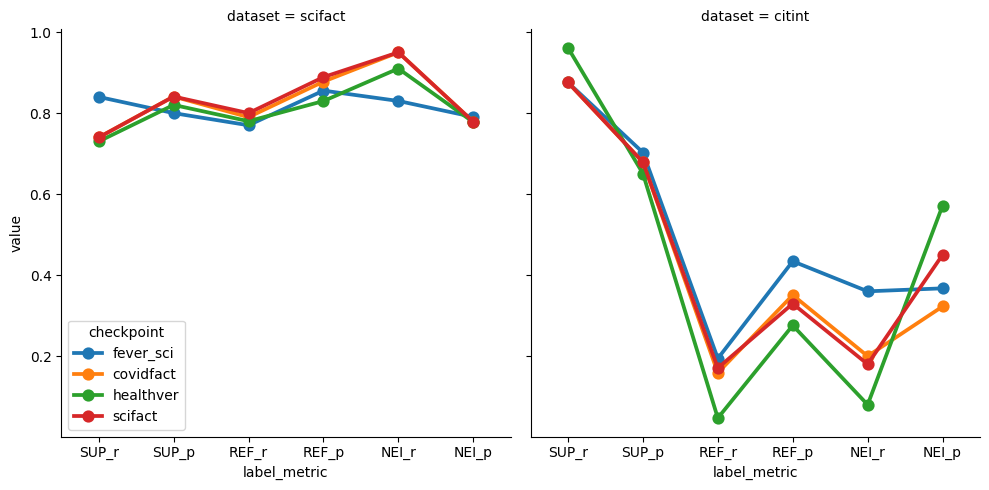

In [3]:
df2 = pd.melt(df, id_vars=['metric', 'dataset', 'checkpoint'], value_name = 'value', var_name = 'label')
# Abbreviate labels and add _p or _r
df2['label_metric'] = df2['label'].str[:3]+'_'+df2['metric'].str[0]
plot_ = sns.catplot(data=df2, col='dataset', x='label_metric', y='value', hue='checkpoint', kind='point', legend_out=False)

## Experiment with rationale_weight

`rationale_weight` is a hyperparameter in the MultiVers model that controls retrieval of evidence sentences (rationales) from the abstracts.
Higher values make the rationale sentences more important in the loss function.
The MultiVers paper uses a `rationale_weight` of 15, but the Citation-Integrity paper uses a `rationale_weight` of 0 (turns off sentence retrieval and uses the whole abstract).

In [4]:
# Start with empty DataFrame
df = pd.DataFrame()
columns = ['SUPPORT', 'REFUTE', 'NEI', 'micro', 'macro']
# Loop over metrics
for metric in ['recall', 'precision']:
    
    # Loop over datasets and checkpoints
    for dataset in ['scifact', 'citint']:
        for rationale_weight in [0, 15]:
            data = eval.read_data(f'../data/{dataset}', 'test')
            predictions = eval.read_predictions(f'../predictions/ckpt_rationale/fever_sci_{dataset}_{rationale_weight}.jsonl')
            values = eval.calc_metric(data, predictions, metric)
            values_df = pd.DataFrame([values], columns = columns)
            values_df['metric'] = metric
            values_df['dataset'] = dataset
            values_df['rationale_weight'] = rationale_weight
            df = pd.concat([df, values_df], ignore_index = True)

# Drop micro and macro averages - we'll just look at scores for each label
df = df.drop(columns = ['micro', 'macro'])

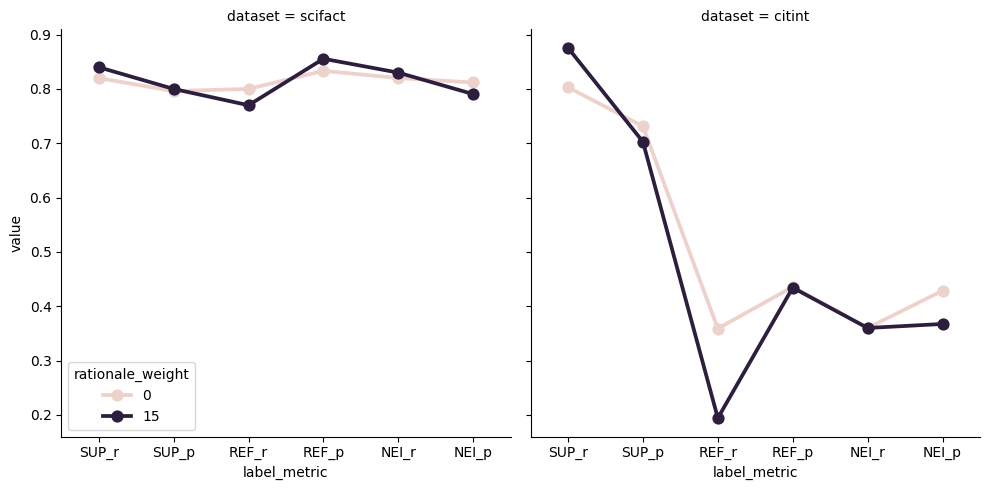

In [5]:
df2 = pd.melt(df, id_vars=['metric', 'dataset', 'rationale_weight'], value_name = 'value', var_name = 'label')
# Abbreviate labels and add _p or _r
df2['label_metric'] = df2['label'].str[:3]+'_'+df2['metric'].str[0]
plot_ = sns.catplot(data=df2, col='dataset', x='label_metric', y='value', hue='rationale_weight', kind='point', legend_out=False)